In [6]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.io import wavfile
from scipy import signal
from tqdm.notebook import tqdm
from tensorflow.keras import datasets, layers, models
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder
import IPython.display as ipd

### Load the meta files for train and test dataset

The meta data can be loaded as a ``pandas.DataFrame`` in Python, where each row coresponds to one bird call/chatter recording. Each recording corresponds to a bird usually found in PNW. The bird names are in shortcodes found in https://ebird.org. 

In [7]:
# load train and test meta data
train_path = 'data/train.csv'
train_df = pd.read_csv(train_path)
test_path = 'data/test.csv'
test_df = pd.read_csv(test_path)
# sampling frequency we will use
FS = 22050
# duration of each sound
T =20
# display train dataset
train_df

,file,bird
0,XC212943,bewwre
1,XC377560,houspa
2,XC313351,amerob
3,XC188131,whcspa
4,XC340598,mallar3
...,...,...
1674,XC193112,amecro
1675,XC481270,rethaw
1676,XC368449,rewbla
1677,XC153552,amegfi


In [8]:
#The ebird codes from ebird.org
LABELS=["amecro","amegfi","amerob","annhum","bewwre","bkcchi"
                             ,"cangoo","comrav","daejun","doccor","grbher3","houfin","houspa",
                             "mallar3","norfli","rebnut","rethaw","rewbla","sonspa","spotow",
                                "stejay","whcspa"]
#Encoder that does the one-hot bit encoding
encoder = OneHotEncoder(sparse_output=False).fit(np.array(LABELS).reshape(-1,1))


### Load the train and test dataset

#### Assignment 1
1.  Use the function ``load_dataset()`` (with parameters ``transform = None`` ) to load train and test dataset. The code for loading the train dataset is already provided in the starter code. You still have to write the code line for loading the test dataset (this is an easy task). ``load_dataset()`` returns a tuple ``(data, labels)``, where ``data`` contains the audio time series organized in a 2D numpy array and ``labels`` contains the labels (One-hot bit encoding of ``ebird_code``) for each audio sample. Each label consists of an array of size 22 with 21 zeros and a single '1' at the position corresponding to the bird type. Each row of ``data`` is a single bird recording and the corresponding row in ``labels`` is the corresponding bird. That is, the audio time series and label of the i-th recording can be accessed by ``audio = data[i]`` and ``label = labels[i]``. 
2. Plot the time series of a single recording using ``plt.plot()`` and play the bird using the ``IPython.display`` function from Lab 2. You can display any recording you like. The x-axis of your plot should be in seconds. Make sure to label both x- and y-axis properly. Print the label (ideally the ebird code) of the corresponding recording.

In [9]:
def load_dataset(path_dataset, path_meta, transform='none', downsample=True):
    """
    path_dataset : str
        path of the folder tht contains the audio samples
    path_meta : str
        path of the metadata file corresponding to the dataset
    transform : str
        'none' for no transform of the data or 'spec' for transforming the data into spectrograms
    downsample : bool
        If True, the audio recording will be downsampled to a frequency of 11025 Hz.
    """
    dataset_meta = pd.read_csv(path_meta)
        
    labels = dataset_meta['bird'].copy()
    labels = encoder.transform(np.array(labels).reshape(-1,1))
    if transform != 'spec':
        audio = np.zeros((len(dataset_meta.file), FS*T,),np.float32)
    else:
        audio = np.zeros((len(dataset_meta.file), 513,int(FS*T/1024)),np.float32)
    i=0
    for file in tqdm(dataset_meta.file):
        fs, audio_single = wavfile.read(path_dataset + file + '.wav')
        audio_single = audio_single[:2*FS*T]
        audio_single =  signal.resample_poly(audio_single*1., 1, 2)[:20*22050]
        audio_single = audio_single / np.max(abs(audio_single)) 
        audio_single = np.pad(audio_single, (0,22050*20-len(audio_single)))
        if transform == 'spec':
            f, t, audio_single = spec2(audio_single, N=1024) #if you cannot finish assignment 3, replace spec by spec2
        audio[i] = audio_single
        i+=1
            
#     audio = np.array(audio)
    if transform == 'spec':
        dim1 = audio.shape[0]
        dim2 = audio.shape[1]
        dim3 = audio.shape[2]
        
        audio = audio.reshape(dim1, dim2, dim3, 1)

    return audio, labels


In [10]:
# load datasets
data_train, labels_train = load_dataset('data/train/', 'data/train.csv', transform=None)
data_test, labels_test = load_dataset('data/test/', 'data/test.csv', transform=None)

  0%|          | 0/1679 [00:00<?, ?it/s]

  0%|          | 0/420 [00:00<?, ?it/s]

[[2]]
amerob


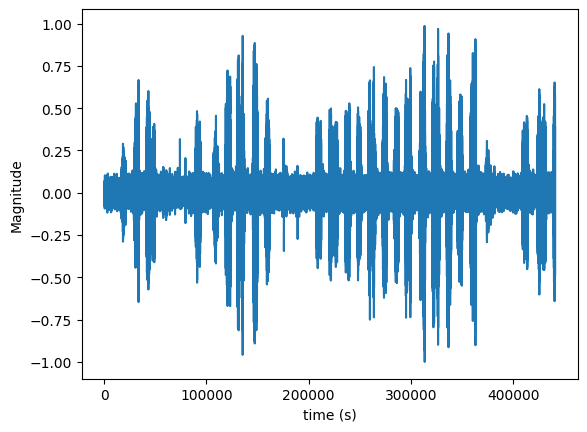

In [11]:
# TODO: plot time series of a single recording either from the test set or the training set
plt.plot(data_test[1])
plt.xlabel('time (s)')
plt.ylabel('Magnitude')
# TODO: print its label (Hint: use np.where())
# bird_type = LABELS[np.where(labels_test[1]==1).astype(int)]
index = np.where(labels_test[1]==1)
index = np.array(index)
print(index) #2
bird_type = LABELS[2]
print(bird_type) #amerob
# TODO: play the recording
ipd.Audio(data_test[1],rate=22050)

#Questions:
# How do we know what bird_label[2] corresponds to?
# what is the y-label?

## A Naive Deep learning Implementation

#### Assigment 2a:
Add at least two additional ``Dense`` layers to the network architecture in the starter code.
You are free to chose the number of neurons, and activation function in each layer.

In [12]:
# model for raw time series data
model = models.Sequential() # groups a linear stack of layers into a tensorflow.keras.Model, basically this builds your model framework

model.add(layers.Dense(50, activation='relu',input_shape=data_train[0].shape))

# TODO add at least 2 more layers to the network 

# Froze Due to Lack of GPU Power
# (optimal number of hidden nueorns should be 2/3 the size of input layer plus output layer)
# neurons = (2/3)*50 +22
# model.add(layers.Dense(neurons, activation='relu'))
# model.add(layers.Dense(neurons+100, activation='relu'))

model.add(layers.Dense(22, activation='sigmoid'))

model.build(data_train[0].shape)
model.summary()

#Questions: 
# Are we supposed to add the input layer?
# How many total layers should we see in the summary?

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 50)                22050050  
                                                                 
 dense_1 (Dense)             (None, 22)                1122      
                                                                 
Total params: 22051172 (84.12 MB)
Trainable params: 22051172 (84.12 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


#### Assigment 2b:
Run the model fitting and describe (in words in a separate markdown cell), how the classification accuracy on the train and test set changes throughout the model training.
Plot train and test set accuracy as a function of epoch number and report the final accuracy on the test set. (The code for that is already provided and all you have to do is execute it.)
Assume, you have a new bird sound sample that the model has not seen before.
How likely do you think is it that the model identifies the right bird.
Comment on that in the notebook.

In [13]:
# compile the model and fit it to the training data
model.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])
history = model.fit(data_train, np.array(labels_train), epochs=10, validation_data=(data_test, np.array(labels_test)), shuffle=True)


Epoch 1/10


10/53 [====>.........................] - ETA: 13s - loss: 0.7056 - accuracy: 0.0469


KeyboardInterrupt



In [ ]:
# plot the accuracy of train and test set throughout the training procedure
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label = 'test accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.ylim([0.0, 1.])

# compute final accuracy on test set
test_loss, test_acc = model.evaluate(data_test, labels_test, verbose=2)
print('test accuracy is : ', test_acc)

## Representing Audio Signals as Spectrograms

#### Assignment 3:
1.  Complete the function ``spec()`` that computes the spectrogram of a single audio signal. The function takes as inputs the audio signal ``x`` and the window length of the STFT ``N``. Assume a window hop size of $T = N$. That is, adjacent segments do not overlap. For the window function we use a simple rectangular window. Your implementation should include the following steps:
    * split the signal $x$ into $K$ segments of length $N$.
	* compute the FFT of each segment and only store the frequency points from $k=0$ to $N/2$ (corresponding to the DTFT frequency from 0 to $\pi$.).
	* Compute the magnitude square according to Eq. 3 in the lab instructions.
	* Compute the normalized spectrogram
		$$\tilde{S}[m,k] = \frac{S[m,k]}{\mathrm{max}\left(S[m,k]\right)}$$.

2. Once you have completed your implementation of ``spec()``, run the code cell that computes the spectrogram of a single bird sound and compare it with numpy's spectrogram function used in ``spec2()``. The two spectrograms you get should look identical.

In [14]:
def spec(x, N):
    """
    Computes the spectrogram of signal x.
    
    x : np.ndarray
        discrete time signal
    N : int
        length of each segment
        
    return (f, t, Sxx), where t is the array of time indies, f, the array of frequency indices, and
    Sxx a 2-dimensional array where each row corresponds to the DFT of a single segment.
    """
    # TODO: split the signal into K segments of length N
    K = len(x) // N
    segments = np.array_split(x[:K*N],K)
    
    # TODO: compute their FFT and store the frequency points between 0 and N/2
    fft_result = np.fft.fft(segments, axis=1)[:, :N//2]
    
    # TODO: Compute the spectrogram
    magnitude_square = np.abs(fft_result)**2
    
    # TODO: Normalize the spectrogram
    Sxx = magnitude_square / np.max(magnitude_square)
    
    # defines time and frequency array
    t = np.arange(0, K, 1)
    f = np.linspace(0, 0.5, int(N/2))
    
    return f, t, np.transpose(Sxx)

def spec2(x, N):
    f, t, Sxx = signal.spectrogram(x, nperseg=N, window='boxcar', noverlap=0)
    Sxx /= np.max(abs(Sxx))
    return f, t, Sxx

C:\Users\stlp\AppData\Local\Temp\ipykernel_7132\168639019.py:17: RuntimeWarning: divide by zero encountered in log10
  Sxx_log = 10*np.log10(Sxx)
C:\Users\stlp\AppData\Local\Temp\ipykernel_7132\168639019.py:28: RuntimeWarning: divide by zero encountered in log10
  Sxx2_log = 10*np.log10(Sxx2)


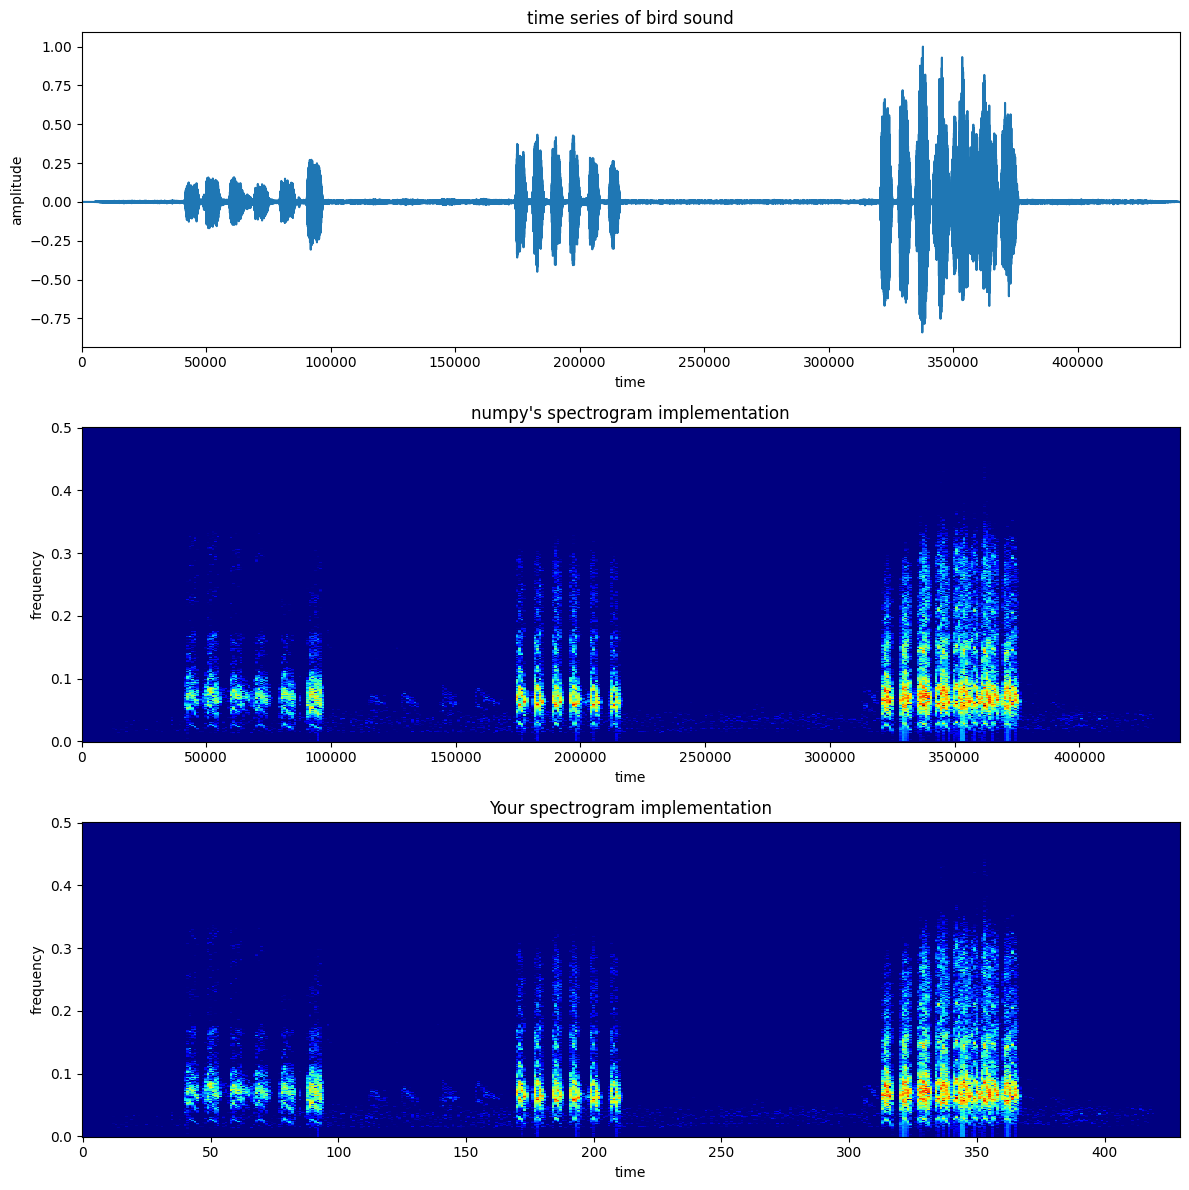

In [15]:
# test spec function on single bird sound. The output should be the same a spec2.
# All you need to to here is to run this cell.
audio_single = data_train[200]

# plot time series
fig, ax = plt.subplots(figsize=(12,12), nrows=3)
plt.subplot(311)
plt.plot(audio_single)
plt.xlim(0, len(audio_single) - 1)
plt.xlabel('time')
plt.ylabel('amplitude')
plt.title('time series of bird sound')

# plot spectrogram using numpy's implementation
f, t, Sxx = spec2(audio_single, N=1024)
plt.subplot(312)
Sxx_log = 10*np.log10(Sxx)
Sxx_log[Sxx_log == -np.inf] = -50
plt.pcolormesh(t, f, Sxx_log, vmin=-50, cmap='jet')
plt.xlabel('time')
plt.ylabel('frequency')
plt.title("numpy's spectrogram implementation")


# plot spectrogram using your implementation
f2, t2, Sxx2 = spec(audio_single, N=1024)
plt.subplot(313)
Sxx2_log = 10*np.log10(Sxx2)
Sxx2_log[Sxx2_log == -np.inf] = -50
plt.pcolormesh(t2, f2, Sxx2_log, vmin=-50, cmap='jet')
plt.xlabel('time')
plt.ylabel('frequency')
plt.title("Your spectrogram implementation")
plt.tight_layout()
plt.show()

## Using Spectrograms and Convolutional Neural Networks to Identify Bird Sounds

#### Assignment 4:
1. Load the train and test set using the ``load_dataset()`` function with the parameter ``transform='spec'`` (you only need to run the corresponding code cell in the starter code).
2. Build the CNN architecture. An initial architecture with one convolutional layer has already been provided in the starter code. Add at least one more convolutional layer followed by a MaxPooling layer to the architecture. The important input parameters of the \textcodefont{Conv2D} layer are
     * ``filters``: number of convolutional kernels
	 * ``kernel_size``: size of each kernel
	 * ``activation``: The activation function that is used for the output of the convolutional layer. You should use the ``'relu'`` function.

  The ``MaxPooling`` layer only takes a ``pool_size`` that is equivalent to the ``kernel_size`` of the convolutional layer.

3. Run the next code cell of the starter notebook to train your architecture. As in Assignment 2, the printout will tell you the accuracy of the classifier on the train and test set after each epoch.
4. As in Assignment 2, plot the accuracy on the train and test set as a function of epoch
5.  Change the parameters of your CNN architecture (number of layers, kernel size, etc.) to get as high of an accuracy on the test set as possible. Describe the observations you make (What changes seem to improve/decrease the test set accuracy? How does the accuracy on train and test set change throughout the training process (i.e., with increasing number of epochs)?). You should be able to get an accuracy of at least 90-95% on the test set.

In [16]:
# Load the spectrograms
data_train_spec, labels_train = load_dataset('data/train/', 'data/train.csv', transform='spec')
data_test_spec, labels_test = load_dataset('data/test/', 'data/test.csv', transform='spec')

  0%|          | 0/1679 [00:00<?, ?it/s]

  0%|          | 0/420 [00:00<?, ?it/s]

In [21]:
# CNN architecture
model = models.Sequential() # groups a linear stack of layers into a tensorflow.keras.Model, basically this builds your model framework

# this one is a conv2D+maxPooling
model.add(layers.Conv2D(filters=32, kernel_size=(5, 5), activation='relu', strides=(2,2),
                        input_shape=data_train_spec.shape[1:]),)
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(filters=32, kernel_size=(5, 5), activation='relu', strides=(2,2),
                        input_shape=data_train_spec.shape[1:]),)
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

# Optional dropout layer to prevent overfitting
model.add(layers.Dropout(.2))
#TODO: add more layers and chnage the parameters of the layers
# Froze Due to Lack of GPU Power
# (optimal number of hidden nueorns should be 2/3 the size of input layer plus output layer)
neurons = (2/3)*50 +22
# model.add(layers.Dense(neurons, activation='relu'))
# model.add(layers.Dense(neurons+100, activation='relu'))


model.add(layers.Flatten())
model.add(layers.Dense(22, activation='sigmoid'))
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 255, 213, 32)      832       
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 127, 106, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 62, 51, 32)        25632     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 31, 25, 32)        0         
 g2D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 31, 25, 32)        0         
                                                                 
 flatten_4 (Flatten)         (None, 24800)            

In [22]:
# train the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(data_train_spec, labels_train, batch_size=32, epochs=16,
                    validation_data=(data_test_spec, labels_test), shuffle=True)

Epoch 1/16
53/53 [==============================] - 37s 649ms/step - loss: 0.2472 - accuracy: 0.0655 - val_loss: 0.1884 - val_accuracy: 0.1405
Epoch 2/16
53/53 [==============================] - 30s 558ms/step - loss: 0.1648 - accuracy: 0.2091 - val_loss: 0.1585 - val_accuracy: 0.3167
Epoch 3/16
53/53 [==============================] - 29s 556ms/step - loss: 0.1382 - accuracy: 0.4032 - val_loss: 0.1603 - val_accuracy: 0.2976
Epoch 4/16
53/53 [==============================] - 30s 558ms/step - loss: 0.1212 - accuracy: 0.5051 - val_loss: 0.1633 - val_accuracy: 0.3238
Epoch 5/16
53/53 [==============================] - 30s 564ms/step - loss: 0.1072 - accuracy: 0.5670 - val_loss: 0.1756 - val_accuracy: 0.3167
Epoch 6/16
53/53 [==============================] - 30s 564ms/step - loss: 0.0920 - accuracy: 0.6557 - val_loss: 0.1935 - val_accuracy: 0.3190
Epoch 7/16
53/53 [==============================] - 30s 574ms/step - loss: 0.0750 - accuracy: 0.7362 - val_loss: 0.2135 - val_accuracy: 0.3286

In [1]:
# plot the accuracy of train and test set throughout the training procedure
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label = 'test accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.ylim([0.0, 1.])

# compute final accuracy on test set
test_loss, test_acc = model.evaluate(data_test, labels_test, verbose=2)
print('test accuracy is : ', test_acc)


#Accuracy = 35 ish % 

NameError: name 'plt' is not defined